In [1]:
%matplotlib inline
from solveFull import linearSolve_krylov as linearSolve
import numpy as np, matplotlib.pyplot as plt
import pystokes

In [2]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

In [3]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## squirmer
D0  = 1.0      
S0  = 3/50*D0    # beta = 1 (positive beta is a puller (negative V2s)) - not sure which sign!

In [4]:
## initialise 
#initial position
r = np.array([-1.5,1.5, 0.,0. , 0., 0.])

#initial orientation
p = np.array([0., 0., 0.,0., 1.,1.])

##rotate particles 50deg towards each other
p[::Np] = rotation(p[::Np], 0., 25*2*np.pi/360, 0.)
p[1::Np] = rotation(p[1::Np], 0., -25*2*np.pi/360, 0.)


# initial slip modes
S = np.zeros(9*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yx, yy, yz, zx, zy, zz
    S[i]       = S0*(3*p[i]*p[i] -1.)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i])
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+Np]-1.)
    S[i + 5*Np]= S0*(3*p[i+Np]*p[i+2*Np]) 
    S[i + 6*Np]= S0*(3*p[i+2*Np]*p[i])
    S[i + 7*Np]= S0*(3*p[i+2*Np]*p[i+Np])
    S[i + 8*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

In [5]:
def rhs(rp): ##change this to give polarisation directly
    """
    Function that gives rhs for equations dr/dt=v and dp/dt= o x p
    """
    
    #position and angle theta (relative to initial angle)
    r = rp[0:3*Np]; p = rp[3*Np:6*Np]
    
    ## make sure orientations remain unit length
    #norm_p1 = np.dot(p[::Np],p[::Np])
    #norm_p2 = np.dot(p[1::Np],p[1::Np])
    
    #p[::Np] = p[::Np]/np.sqrt(norm_p1)
    #p[1::Np] = p[1::Np]/np.sqrt(norm_p2)
    
    
    F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
    
    for i in range(Np):          
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0 
        
        T[i]      = 0.0
        T[i+Np]   = 0.0
        T[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
        
        S[i]       = S0*(3*p[i]*p[i] -1.)
        S[i + Np]  = S0*(3*p[i]*p[i+Np])
        S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
        S[i + 3*Np]= S0*(3*p[i+Np]*p[i])
        S[i + 4*Np]= S0*(3*p[i+Np]*p[i+Np]-1.)
        S[i + 5*Np]= S0*(3*p[i+Np]*p[i+2*Np]) 
        S[i + 6*Np]= S0*(3*p[i+2*Np]*p[i])
        S[i + 7*Np]= S0*(3*p[i+2*Np]*p[i+Np])
        S[i + 8*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)
        
        D[i]       = D0*p[i]
        D[i+Np]    = D0*p[i+Np]
        D[i+2*Np]  = D0*p[i+2*Np]

    
    #update repulsive force at position r
    forces.lennardJones(F, r, lje=5.0, ljr=2.1*b)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    ls.RBM(v, o, r, F, T, S, D)
    
    dpdt = np.zeros(3*Np)
    
    for i in range(Np):
        dpdt[i]      = o[i+Np]*p[i+2*Np] - o[i+2*Np]*p[i+Np]    
        dpdt[i+Np]   = o[i+2*Np]*p[i   ] - o[i     ]*p[i+2*Np]  
        dpdt[i+2*Np] = o[i     ]*p[i+Np] - o[i+Np  ]*p[i]
        

    
    #return velocity and angular velocity cross orientation as right-hand side
    return np.concatenate( (v,dpdt) )

In [6]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=None, **kwargs)
        
    return X

In [7]:
%%time
#initiallize system and forces
ls = linearSolve(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 300.
Npts = 10

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1000,
             method='BDF')
X.message

CPU times: user 3min 46s, sys: 54.1 ms, total: 3min 46s
Wall time: 3min 29s


'The solver successfully reached the end of the integration interval.'

In [8]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [9]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

In [10]:
plt.rcParams.update({'font.size': 17})

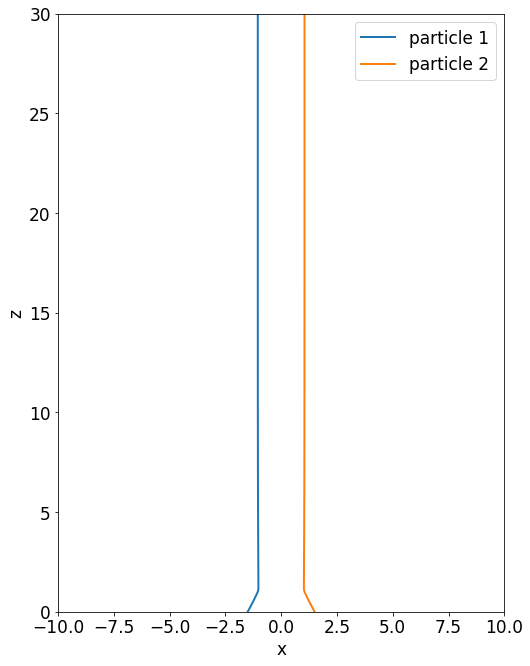

In [25]:
##x-y plot like in Ishikawa
plt.figure(figsize=(8,11))
plt.plot(pos1[:,0], pos1[:,2], label='particle 1', lw=2)
plt.plot(pos2[:,0], pos2[:,2], label='particle 2', lw=2)
plt.xlabel('x')
plt.ylabel('z')
plt.ylim(0,30)
plt.xlim(-10,10)
plt.legend()
plt.show()

In [26]:
## minimum distance between the two particles
rmin = np.amin(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmax = np.amax(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmin, rmax

(2.0373132316127966, 3.0)

In [27]:
minIndex = np.where(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2)==rmin)
#minIndex[0][0] -= 18
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
minIndex

(array([17]),)

In [28]:
xik,yik,zik ##they go out of plane? not anymore! 

(-2.0373132316127966, 0.0, 3.375077994860476e-13)

In [29]:
##why does Krylov solver go so wrong? seems to introduce numerical error. 

## Try symmetry factor corrected matrix elements with a direct solver? 

In [30]:
print(pos1[:,0] + pos2[:,0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.22044605e-16  0.00000000e+00  2.22044605e-16
 -2.22044605e-16  2.22044605e-16 -4.32986980e-14 -1.62092562e-14
 -9.76996262e-15 -8.21565038e-15 -8.65973959e-15 -9.10382880e-15
 -4.61630734e-13 -1.23634436e-12 -1.94577687e-12 -2.12962981e-12
 -2.09476880e-12 -4.12714307e-12 -5.49960077e-12 -6.77680134e-12
 -8.23363600e-12 -9.37916411e-12 -1.08051346e-11 -1.24404931e-11
 -1.42528211e-11 -1.84401383e-11 -2.36108910e-11 -3.02191605e-11
 -3.85549370e-11 -7.26088079e-11 -1.46103796e-10 -2.92187385e-10
 -5.58601831e-10 -1.02047237e-09 -2.10873874e-09 -3.99492883e-09
 -6.98088520e-09 -1.14031147e-08 -2.86621933e-08 -6.86778210e-08
 -1.59318499e-07 -3.51196348e-07  3.92057205e-06 -2.66578392e-05]


In [31]:
orientations = X.y.T[:,3*Np:6*Np]
or1 = orientations[:,::Np]
or2 = orientations[:,1::Np]

In [32]:
or1[:,0] + or2[:,0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.33066907e-16,  7.21644966e-16,  9.99200722e-16,  1.05471187e-15,
       -1.71529457e-14, -5.06816811e-14, -8.64863736e-14, -1.58539848e-13,
       -2.40724107e-13, -4.32515135e-13, -9.58136348e-13, -1.84989524e-12,
       -2.78201420e-12, -3.39492323e-12, -4.11561844e-12, -4.91297281e-12,
       -5.78338766e-12, -7.73218295e-12, -9.99092475e-12, -1.25117139e-11,
       -1.52536039e-11, -2.42131870e-11, -4.51935434e-11, -9.75685088e-11,
       -2.05659600e-10, -3.89168503e-10, -7.61497837e-10, -1.29289848e-09,
       -1.99396458e-09, -2.88217678e-09, -6.88570373e-09, -1.75809524e-08,
       -4.05375677e-08, -8.42435163e-08,  5.77570598e-07, -4.82057388e-06])

In [33]:
or1[:,2] - or2[:,2]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.11022302e-16, -2.22044605e-16, -2.22044605e-16, -3.33066907e-16,
       -5.55111512e-16,  8.88178420e-16,  4.21884749e-15,  3.33066907e-16,
       -1.18793864e-14,  2.91433544e-13,  4.23550084e-13,  3.74700271e-13,
        3.11306536e-13,  2.87103674e-13,  2.29372077e-13,  1.27009514e-13,
       -4.21884749e-15, -3.63487018e-13, -8.75521877e-13, -1.51800794e-12,
       -2.22644125e-12, -1.87116989e-12,  3.81472631e-12,  1.21991306e-11,
        1.17037491e-11, -9.77962156e-12, -7.80066012e-11, -1.89002813e-10,
       -3.39511752e-10, -5.22392796e-10, -5.56014124e-10, -1.79594672e-09,
       -5.42417566e-09, -1.26941860e-08,  9.72668542e-08, -7.98725019e-07])

In [34]:
X.nfev

125

In [35]:
S[::Np]

array([-0.05516642, -0.        , -0.02911802, -0.        , -0.06      ,
        0.        , -0.02911802,  0.        ,  0.11541014])

In [36]:
S[1::Np]

array([-0.0551667 ,  0.        ,  0.02911721,  0.        , -0.06      ,
        0.        ,  0.02911721,  0.        ,  0.11541041])

In [37]:
np.dot(p[::Np],p[::Np])

1.0